In [ ]:
# !pip install numpy
# !pip install pandas
# !pip install torch
# !pip install sklearn
# !pip install pytorch-tabnet==3.1.1

: 

In [1]:
import numpy as np
import pandas as pd
import torch

from torch import nn
from pytorch_tabnet.tab_model  import TabNetClassifier 
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

In [30]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(train.shape)
train.head(3)


(501951, 35)


,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,target
0,0,True,True,True,False,False,False,1,4,3,...,2,1608,275,1,4,139,618822,354805,2020-01-17 12:09:36,1
1,1,False,False,False,True,True,False,1,3,4,...,2,1608,275,1,4,133,571659,346213,2020-06-18 17:48:52,0
2,2,False,False,False,True,False,False,2,0,3,...,1,1600,94,1,4,53,399816,206408,2020-07-08 20:00:10,0


### Data : 시간에 따른 Target 분포 파악

In [31]:
from datetime import datetime
date = train['contents_open_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
date

0        2020-01-17 12:09:36
1        2020-06-18 17:48:52
2        2020-07-08 20:00:10
3        2020-01-13 18:09:34
4        2020-03-09 20:39:22
                 ...        
501946   2020-03-13 12:55:52
501947   2020-01-20 11:51:51
501948   2020-08-05 17:27:24
501949   2020-06-15 09:23:21
501950   2020-05-25 14:34:48
Name: contents_open_dt, Length: 501951, dtype: datetime64[ns]

In [32]:
date = pd.DataFrame(date)
date['year'] = date['contents_open_dt'].apply(lambda x : x.timetuple()[0])
date['month'] = date['contents_open_dt'].apply(lambda x : x.timetuple()[1])
date['day'] = date['contents_open_dt'].apply(lambda x : x.timetuple()[2])
date['hour'] = date['contents_open_dt'].apply(lambda x : x.timetuple()[3])
date['id'] = train['id']
date.head(3)

,contents_open_dt,year,month,day,hour,id
0,2020-01-17 12:09:36,2020,1,17,12,0
1,2020-06-18 17:48:52,2020,6,18,17,1
2,2020-07-08 20:00:10,2020,7,8,20,2


In [33]:
train = train.merge(date, on ='id', how='left')
train.head(3)

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,contents_attribute_h,person_rn,contents_rn,contents_open_dt_x,target,contents_open_dt_y,year,month,day,hour
0,0,True,True,True,False,False,False,1,4,3,...,139,618822,354805,2020-01-17 12:09:36,1,2020-01-17 12:09:36,2020,1,17,12
1,1,False,False,False,True,True,False,1,3,4,...,133,571659,346213,2020-06-18 17:48:52,0,2020-06-18 17:48:52,2020,6,18,17
2,2,False,False,False,True,False,False,2,0,3,...,53,399816,206408,2020-07-08 20:00:10,0,2020-07-08 20:00:10,2020,7,8,20


In [34]:
train = train.drop(columns = ['contents_open_dt_x', 'contents_open_dt_y'])

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

hour: 
15    37581
16    36621
14    36206
11    34883
12    33216
13    33126
17    33116
10    31445
18    26177
20    23716
21    23381
19    23110
9     21908
22    21660
23    18230
0     14147
8     12751
1      9931
7      8312
2      6426
6      4859
3      4446
5      3356
4      3347
Name: hour, dtype: int64


C:\Users\jeff\workspace\python\venvs\myproject\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='hour', ylabel='count'>

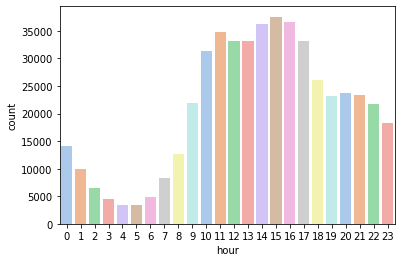

In [45]:
print("hour: ")
print(train['hour'].value_counts())

x = 'hour'
y = 'target'

sns.countplot('hour', data =train, palette='pastel')

C:\Users\jeff\workspace\python\venvs\myproject\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


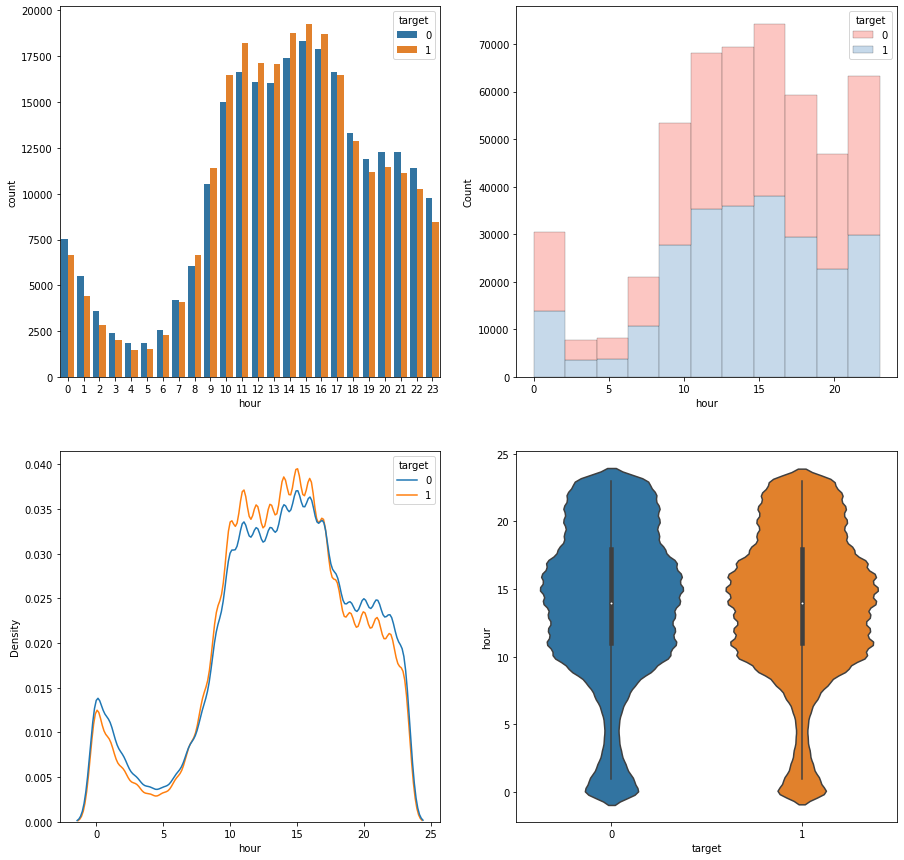

In [46]:
f, ax = plt.subplots(2,2, figsize=(15,15))

sns.countplot(x, hue = y, data =train, ax=ax[0][0])
sns.histplot(train,
            x = x,
            hue=y,
            multiple="stack", 
            palette="Pastel1",
            edgecolor=".10",
            linewidth=".20",
            bins = 11,
            ax = ax[0][1])
sns.kdeplot(data=train, x=x, hue=y, ax=ax[1][0])
sns.violinplot(data=train, x=y, y=x, ax=ax[1][1])
plt.show()

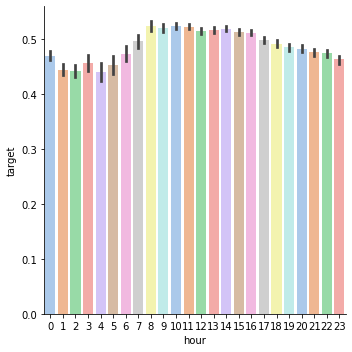

In [47]:
sns.catplot(x=x, y=y, kind="bar", data=train, palette='pastel')


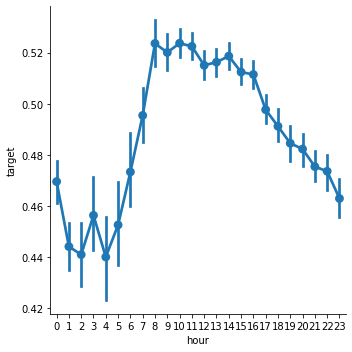

In [48]:
sns.catplot(x=x, y=y, kind="point", data=train)
